**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources: [Kishan Manani](https://github.com/KishManani). Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

# Time Series Analysis

This notebook illustrates the use of MSTL [1] to decompose a time series into a: trend component, multiple season components, and a residual component. MSTL uses STL (Seasonal-Trend decomposition using LOESS) to iteratively extract seasonal components from a time series. The key inputs into MSTL are:

* periods - The period of each seasonal component (e.g., for hourly data with daily and weekly seasonality we would have: periods=(24, 24*7).
* windows - The lengths of each seasonal smoother with respect to each period. If these are large then the seasonal component will show less variability over time. Must be odd. If None a set of default values determined by experiments conducted in [1] are selected.
* lmbda - The lambda parameter for a Box-Cox transformation prior to decomposition. If None then no transformation is done. If "auto" then an appropriate value for lambda is automatically selected from the data.
* iterate - Number of iterations to use to refine the seasonal component.
* stl_kwargs - All the other parameters which can be passed to STL (e.g., robust, seasonal_deg, etc.). See STL docs.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import MSTL

In [2]:
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

In [3]:
df.head()

,Date,Period,OperationalLessIndustrial,Industrial
0,37257,1,3535.867064,1086.132936
1,37257,2,3383.499028,1088.500972
2,37257,3,3655.527552,1084.472448
3,37257,4,3510.446636,1085.553364
4,37257,5,3294.697156,1081.302844


The entries in the date column are integers representing the number of days since 1899-12-30. The Period integers refer to 30 minute intervals in a 24 hour day, hence there are 48 for each day.

Let's extract the date and datetime.

In [4]:
df["Date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)
df["ds"] = df["Date"] + pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

In [5]:
timeseries = df[["ds", "OperationalLessIndustrial"]]
timeseries.columns = [
    "ds",
    "y",
]  # Rename to OperationalLessIndustrial to y for simplicity.

# Filter for first 149 days of 2012.
start_date = pd.to_datetime("2012-01-01")
end_date = start_date + pd.Timedelta("149D")
mask = (timeseries["ds"] >= start_date) & (timeseries["ds"] < end_date)
timeseries = timeseries[mask]

# Resample to hourly
timeseries = timeseries.set_index("ds").resample("H").sum()
timeseries.head()

,y
ds,
2012-01-01 00:00:00,7926.529376
2012-01-01 01:00:00,7901.826990
2012-01-01 02:00:00,7255.721350
2012-01-01 03:00:00,6792.503352
2012-01-01 04:00:00,6635.984460


In [6]:
# Compute date time variables used later in plotting
timeseries["week"] = timeseries.index.isocalendar().week
timeseries["day_of_month"] = timeseries.index.day
timeseries["month"] = timeseries.index.month

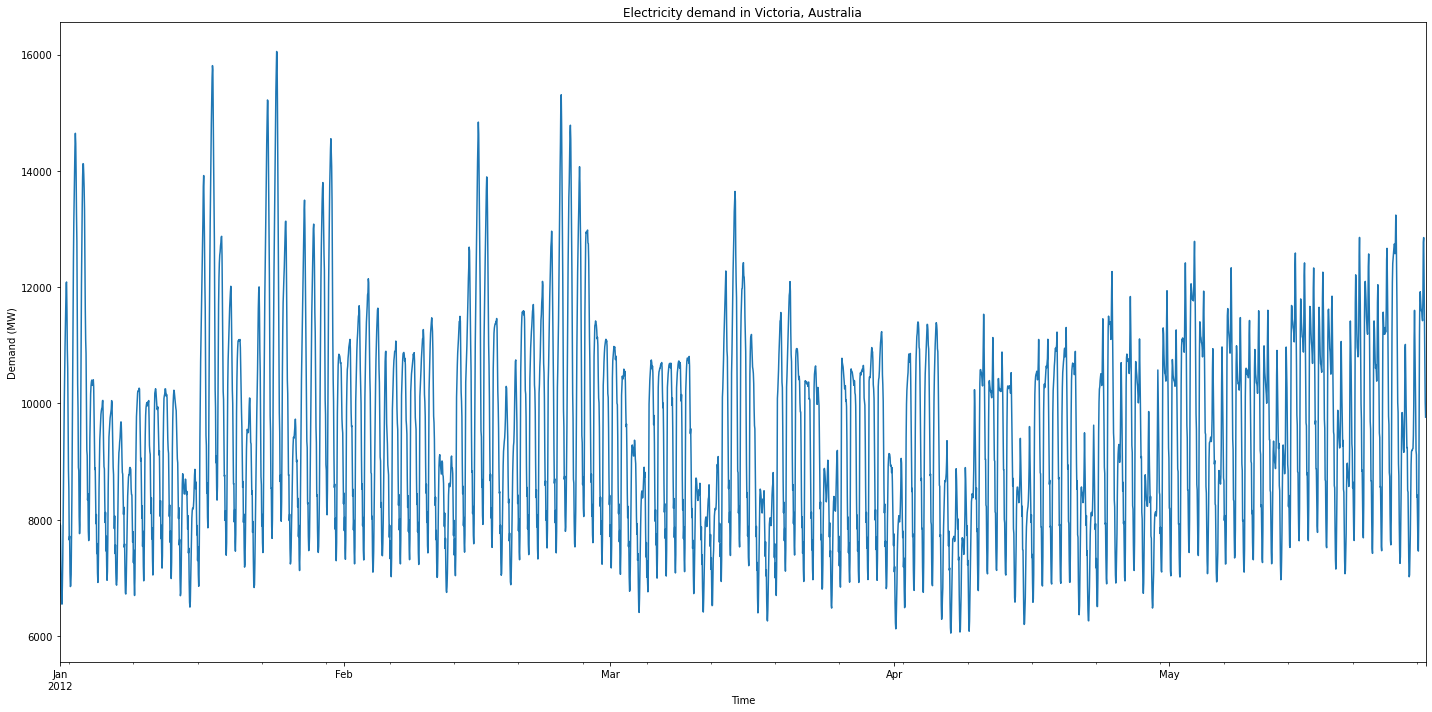

In [7]:
# Plot the time series
ax = timeseries.plot(y="y", figsize=[20, 10], legend=False)
ax.set_ylabel("Demand (MW)")
ax.set_xlabel("Time")
ax.set_title("Electricity demand in Victoria, Australia")
plt.tight_layout()

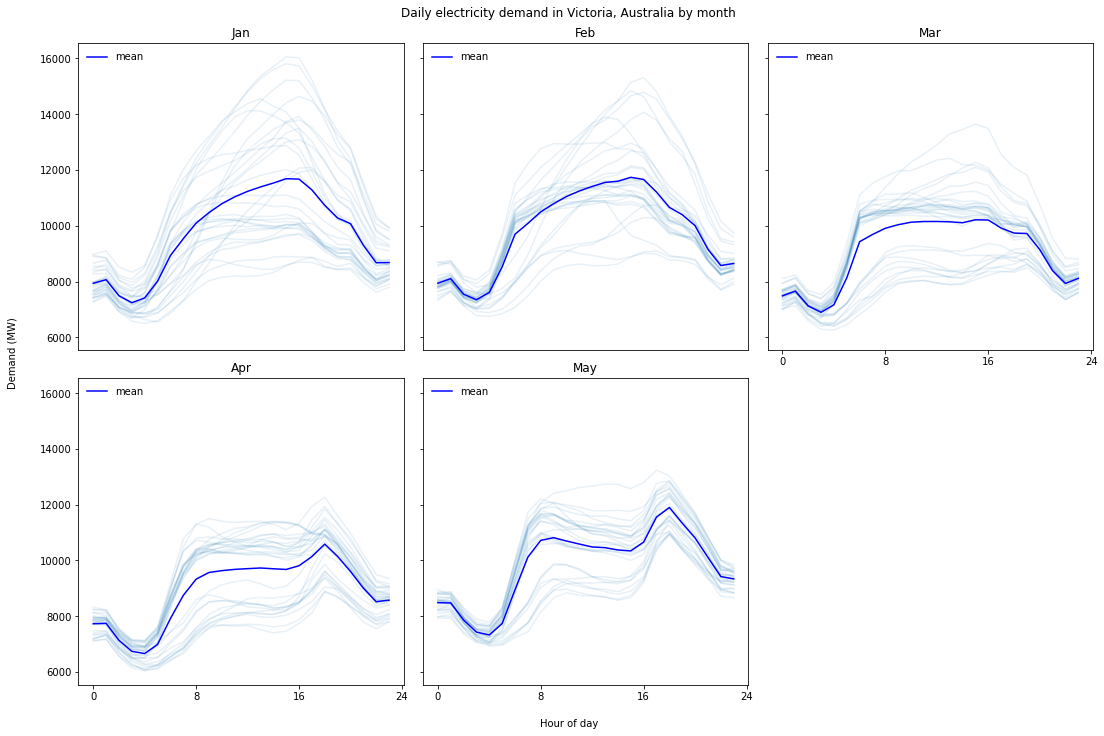

In [8]:
# Plot the electricity demand for each day
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[15, 10], sharey=True)
ax = ax.flatten()
sns_blue = sns.color_palette(as_cmap=True)[0]
MONTHS = ["Jan", "Feb", "Mar", "Apr", "May"]
for ix, month in enumerate(MONTHS):

    # Plot individual ts
    daily_ts = []
    for _, ts in (
        timeseries[["y", "day_of_month", "month"]]
        .query(f"month == {ix+1}")
        .groupby("day_of_month")
    ):
        daily_ts.append(ts.reset_index()["y"])
        ts.reset_index()["y"].plot(
            alpha=0.1, ax=ax[ix], color=sns_blue, label="_no_legend_"
        )
        ax[ix].set_xticks(np.arange(0, len(ts) + 1, 8))
        ax[ix].set_title(month)

    # Plot the mean ts
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(
        ax=ax[ix], color="blue", label="mean", legend=True
    )
    ax[ix].legend(loc="upper left", frameon=False)

    if month in ("Jan", "Feb"):
        ax[ix].tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

fig.text(0.5, -0.02, "Hour of day", ha="center")
fig.text(-0.02, 0.5, "Demand (MW)", va="center", rotation="vertical")
fig.suptitle("Daily electricity demand in Victoria, Australia by month")
fig.delaxes(ax[-1])
fig.tight_layout()

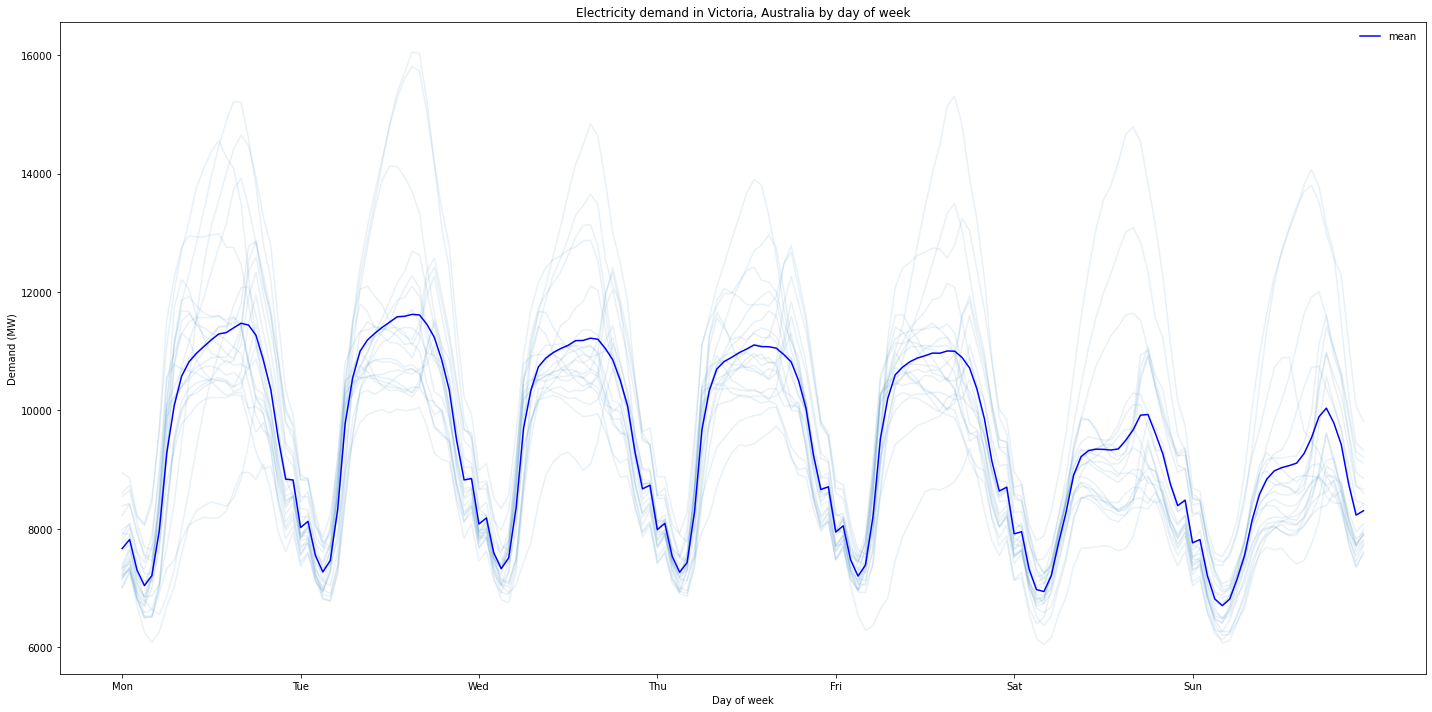

In [9]:
fig, ax = plt.subplots(figsize=[20, 10])
weekly_ts = []
sns_blue = sns.color_palette(as_cmap=True)
DAYS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
for week, ts in timeseries.groupby("week"):
    weekly_ts.append(ts.reset_index()["y"])
    ts.reset_index()["y"].plot(alpha=0.1, ax=ax, label="_no_legend_", color=sns_blue)
    plt.xticks(ticks=np.arange(0, 167, 24), labels=DAYS)

pd.concat(weekly_ts, axis=1).mean(axis=1).plot(
    ax=ax, color="blue", label="mean", legend=True
)

ax.set_ylabel("Demand (MW)")
ax.set_title("Electricity demand in Victoria, Australia by day of week")
ax.set_xlabel("Day of week")
ax.legend(loc="upper right", frameon=False)

plt.tight_layout()

In [10]:
mstl = MSTL(timeseries["y"], periods=(24, 24 * 7), stl_kwargs={"seasonal_deg": 0})
res = mstl.fit() 

NameError: name 'MSTL' is not defined

In [ ]:
res.trend.head()

In [11]:
res.seasonal.head()

NameError: name 'res' is not defined

In [12]:
res.resid.head()

NameError: name 'res' is not defined

In [ ]:
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

ax_last = axs[-1]
ax_last.xaxis.set_ticks(pd.date_range(start="2012-01-01", freq="MS", periods=5))
plt.setp(ax_last.get_xticklabels(), rotation=0, horizontalalignment="center")
for ax in axs[:-1]:
    ax.get_shared_x_axes().join(ax, ax_last)
    ax.xaxis.set_ticks(pd.date_range(start="2012-01-01", freq="MS", periods=5))
    ax.set_xticklabels([])
axs[0].set_ylabel("y")
axs[0].set_title("Time series decomposition of electricity demand")
ax_last.set_xlabel("Time")

plt.tight_layout()

Let's inspect the seasonal components in a bit more detail and look at the first few days and weeks to examine the daily and weekly seasonality.

We start with daily seasonality. One of the advantages of MSTL is that is allows us to capture seasonality which changes over time. We saw above that the daily seasonality is different in the summer and winter. So let's look at the daily seasonality from MSTL during January and May.

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=[15, 10])
ax = ax.flatten()

# Plot daily seasonality in January
res.seasonal["seasonal_24"].iloc[: 24 * 3].plot(
    ax=ax[0], label="daily seasonality (Jan)", legend=True
)
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].legend(loc="upper right", framealpha=0.9)

# Plot daily seasonality in May
mask = res.seasonal.index.month == 5
res.seasonal[mask]["seasonal_24"].iloc[: 24 * 3].plot(
    ax=ax[1], label="daily seasonality (May)", legend=True
)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="upper right", framealpha=0.9)

# Figure labels
fig.suptitle("Daily seasonal component from MSTL in January and May", fontsize=25)
fig.text(0.5, 0, "Time", ha="center", fontsize=25)
fig.text(-0.02, 0.5, "Seasonal_24", va="center", rotation="vertical", fontsize=25)

plt.tight_layout()

We can see that the daily seasonality of electricity demand is well captured by MSTL. We see a single peak in January and two peaks in May.

We saw previously that weekends and weekdays have different demand. Let's see if this is picked up in the weekly seasonality.

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=[15, 10])
ax = ax.flatten()

# Plot weekly seasonality in January
start = pd.Timestamp("2012-01-09")  # Monday
end = start + pd.Timedelta("3W")
res.seasonal["seasonal_168"].loc[start:end].plot(
    ax=ax[0], label="weekly seasonality (Jan)", legend=True
)
ax[0].set_ylabel("seasonal_168")
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].legend(loc="lower left", framealpha=0.9, fontsize=18)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.253,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.585,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.92,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

weekends = [
    ("2012-01-14", "2012-01-16"),
    ("2012-01-21", "2012-01-23"),
    ("2012-01-28", "2012-01-30"),
]
for start_, end_ in weekends:
    ax[0].axvspan(start_, end_, alpha=0.1, color="red")

# Plot weekly seasonality in May
mask = res.seasonal.index.month == 5
start = pd.Timestamp("2012-05-7")
end = start + pd.Timedelta("3W")
res.seasonal[mask]["seasonal_168"].loc[start:end].plot(
    ax=ax[1], label="weekly seasonality (May)", legend=True
)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="lower left", framealpha=0.9, fontsize=18)

weekends = [
    ("2012-05-12", "2012-05-14"),
    ("2012-05-19", "2012-05-21"),
    ("2012-05-26", "2012-05-28"),
]
for start_, end_ in weekends:
    ax[1].axvspan(start_, end_, alpha=0.1, color="red")

# Figure labels
fig.suptitle("Weekly seasonal component from MSTL in January and May", fontsize=25)
fig.text(0.5, 0, "Time", ha="center", fontsize=25)
fig.text(-0.02, 0.5, "Seasonal_168", va="center", rotation="vertical", fontsize=25)

plt.tight_layout()